In [1]:
import os
import pandas as pd
import tensorflow as tf
from keras import Model
from keras.models import  Sequential
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import GlobalAveragePooling2D, BatchNormalization, Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.applications import EfficientNetB0
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

## Loading data

In [172]:
def load_data(dataset_path):
    def extract_age(file_name):
        return int(file_name.split('_')[0])

    def extract_file_path(file_name):
        return os.path.join(dataset_path, file_name)

    file_names = os.listdir(dataset_path)
    ages = pd.Series(file_names).apply(extract_age)
    file_paths = pd.Series(file_names).apply(extract_file_path)

    df = pd.DataFrame({'Images': file_paths, 'Ages': ages})

    return df


dataset_path = '../../Datasets/IMDB-WIKI-200/'
df = load_data(dataset_path)

dataset_path = '../../Datasets/UTKFace/'
df = pd.concat([df,load_data(dataset_path)])

df # 100k images

,Images,Ages
0,../../Datasets/IMDB-WIKI-200/0_32851434_1960-1...,0
1,../../Datasets/IMDB-WIKI-200/0_34853027_2012-0...,0
2,../../Datasets/IMDB-WIKI-200/0_6802033_1964-01...,0
3,../../Datasets/IMDB-WIKI-200/0_nm0000233_rm176...,0
4,../../Datasets/IMDB-WIKI-200/0_nm0001580_rm347...,0
...,...,...
23703,../../Datasets/UTKFace/9_1_3_20161220222856346...,9
23704,../../Datasets/UTKFace/9_1_3_20170104222949455...,9
23705,../../Datasets/UTKFace/9_1_4_20170103200637399...,9
23706,../../Datasets/UTKFace/9_1_4_20170103200814791...,9


## Preparing data

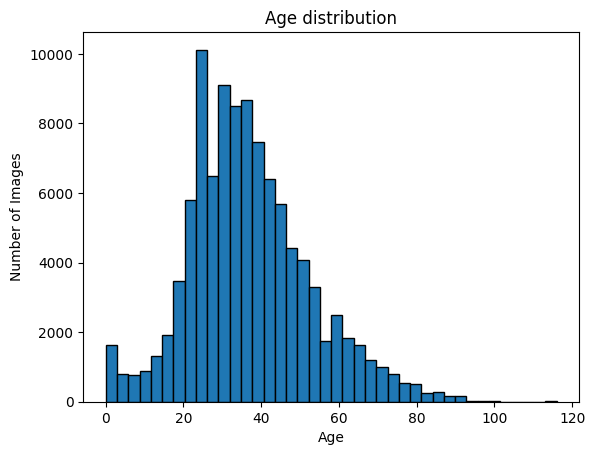

In [173]:
plt.hist(df['Ages'], bins=40, edgecolor='black')
plt.title('Age distribution')
plt.xlabel('Age')
plt.ylabel('Number of Images')
plt.show()

In [174]:
from sklearn.utils import resample

# define maximum number of samples to keep

# Split dataframe into several based on 'Ages'
dfs = [x for _, x in df.groupby('Ages')]

# Resample each dataframe
for i in range(len(dfs)):
    if i>80 or i<1:
        dfs[i] = None
    elif dfs[i].shape[0] < 2:
        dfs[i] = None

# Concatenate dataframes
df = pd.concat(dfs)  # 23k images


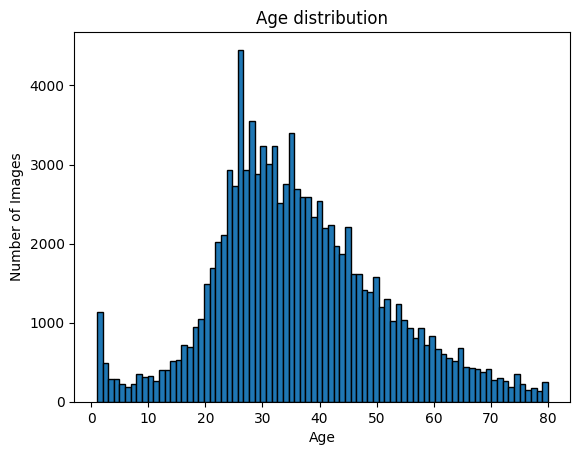

In [175]:
plt.hist(df['Ages'], bins=80, edgecolor='black')
plt.title('Age distribution')
plt.xlabel('Age')
plt.ylabel('Number of Images')
plt.show()


## Splitting data

In [21]:
train_df, test_df = train_test_split(df, stratify=df['Ages'], test_size=0.2, random_state=42)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)



train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='Images',
    y_col='Ages',
    target_size=(200,200),
    color_mode='grayscale',
    class_mode='raw',
    batch_size=32
)

validation_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='Images',
    y_col='Ages',
    target_size=(200,200),
    color_mode='grayscale',
    shuffle=False,
    class_mode='raw',
    batch_size=32,
)

Found 81984 validated image filenames.
Found 20496 validated image filenames.


## Creating CNN

In [ ]:

agemodel = Sequential()

agemodel.add(Conv2D(32, 5, activation='relu', input_shape=(200, 200, 1), padding='same'))
agemodel.add(BatchNormalization())
agemodel.add(Conv2D(32, 5, activation='relu', padding='same'))
agemodel.add(BatchNormalization())
agemodel.add(Conv2D(32, 5, activation='relu', padding='same'))
agemodel.add(BatchNormalization())
agemodel.add(Conv2D(32, 5, activation='relu', padding='same'))
agemodel.add(BatchNormalization())
agemodel.add(MaxPooling2D((2, 2)))

agemodel.add(Conv2D(64, 5, activation='relu', padding='same'))
agemodel.add(BatchNormalization())
agemodel.add(Conv2D(64, 5, activation='relu', padding='same'))
agemodel.add(BatchNormalization())
agemodel.add(Conv2D(64, 5, activation='relu', padding='same'))
agemodel.add(BatchNormalization())
agemodel.add(Conv2D(64, 5, activation='relu', padding='same'))
agemodel.add(BatchNormalization())
agemodel.add(MaxPooling2D((2, 2)))

agemodel.add(Conv2D(128, 5, activation='relu', padding='same'))
agemodel.add(BatchNormalization())
agemodel.add(Conv2D(128, 5, activation='relu', padding='same'))
agemodel.add(BatchNormalization())
agemodel.add(Conv2D(128, 5, activation='relu', padding='same'))
agemodel.add(BatchNormalization())
agemodel.add(Conv2D(128, 5, activation='relu', padding='same'))
agemodel.add(BatchNormalization())
agemodel.add(MaxPooling2D((2, 2)))

agemodel.add(Conv2D(256, 5, activation='relu', padding='same'))
agemodel.add(BatchNormalization())
agemodel.add(Conv2D(256, 5, activation='relu', padding='same'))
agemodel.add(BatchNormalization())
agemodel.add(Conv2D(256, 5, activation='relu', padding='same'))
agemodel.add(BatchNormalization())
agemodel.add(Conv2D(256, 5, activation='relu', padding='same'))
agemodel.add(BatchNormalization())
agemodel.add(MaxPooling2D((2, 2)))



agemodel.add(Flatten())
agemodel.add(BatchNormalization())
agemodel.add(Dropout(0.5))


agemodel.add(Dense(256, activation='relu'))
agemodel.add(BatchNormalization())
agemodel.add(Dropout(0.5))

agemodel.add(Dense(128, activation='relu'))
agemodel.add(BatchNormalization())
agemodel.add(Dropout(0.5))

agemodel.add(Dense(1, activation='relu'))


opt = tf.keras.optimizers.Adam(learning_rate=0.001)

agemodel.compile(optimizer=opt, loss='mse', metrics=['mae'])


In [13]:
agemodel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 200, 200, 32)      832       
                                                                 
 batch_normalization (BatchN  (None, 200, 200, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 200, 200, 32)      25632     
                                                                 
 batch_normalization_1 (Batc  (None, 200, 200, 32)     128       
 hNormalization)                                                 
                                                                 
 conv2d_2 (Conv2D)           (None, 200, 200, 32)      25632     
                                                                 
 batch_normalization_2 (Batc  (None, 200, 200, 32)     1

## Training

In [11]:
import math
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=math.sqrt(0.1), patience=16, verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)

early_stopping = EarlyStopping(monitor='val_loss', patience=40, verbose=1, mode='min', restore_best_weights=True)

model_dir = '../../Models/age-prediction/'
os.makedirs(model_dir, exist_ok=True)

# Check if file exists and create new filename if necessary
base_model_name = "best_model"
suffix = 0
while True:
    model_name = f"{base_model_name}_{suffix}.h5" if suffix > 0 else f"{base_model_name}.h5"
    model_path = os.path.join(model_dir, model_name)
    if not os.path.exists(model_path):
        break
    suffix += 1

model_checkpoint = ModelCheckpoint(model_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

callbacks = [early_stopping, lr_scheduler, model_checkpoint]


In [12]:
history = agemodel.fit(
    train_generator,
    epochs=512,
    validation_data=validation_generator,
    callbacks=callbacks
)

Epoch 1/512


2023-06-13 12:02:54.670100: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-06-13 12:02:58.605615: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-06-13 12:03:00.102572: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-06-13 12:03:00.111839: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x350a1800 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-06-13 12:03:00.111851: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 3070, Compute Capability 8.6
2023-06-13 12:03:00.131548: I

2562/2562 [==============================] - ETA: 0s - loss: 365.8348 - mae: 14.5642

2023-06-13 12:11:02.118777: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from inf to 221.03650, saving model to ./Models/best_model_28.h5
2562/2562 [==============================] - 528s 200ms/step - loss: 365.8348 - mae: 14.5642 - val_loss: 221.0365 - val_mae: 11.7281 - lr: 0.0010
Epoch 2/512
2562/2562 [==============================] - ETA: 0s - loss: 216.9262 - mae: 11.5443
Epoch 2: val_loss improved from 221.03650 to 193.33582, saving model to ./Models/best_model_28.h5
2562/2562 [==============================] - 522s 204ms/step - loss: 216.9262 - mae: 11.5443 - val_loss: 193.3358 - val_mae: 11.0408 - lr: 0.0010
Epoch 3/512
2562/2562 [==============================] - ETA: 0s - loss: 179.0367 - mae: 10.4174
Epoch 3: val_loss did not improve from 193.33582
2562/2562 [==============================] - 514s 201ms/step - loss: 179.0367 - mae: 10.4174 - val_loss: 290.6559 - val_mae: 13.6820 - lr: 0.0010
Epoch 4/512
2562/2562 [==============================] - ETA: 0s - loss: 149.1535 - mae: 9.4393
Epoch 4: val_loss improved from 

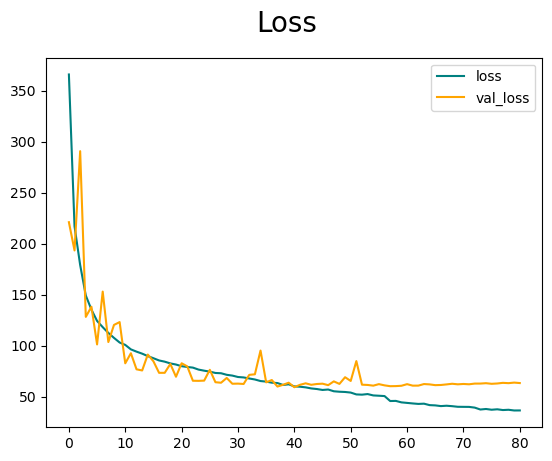

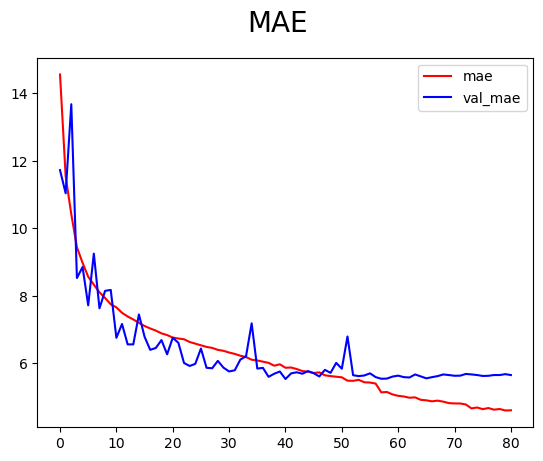

In [25]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper right")
fig2 = plt.figure()
plt.plot(history.history['mae'], color='red', label='mae')
plt.plot(history.history['val_mae'], color='blue', label='val_mae')
fig2.suptitle('MAE', fontsize=20)
plt.legend(loc="upper right")
plt.show()


## Saving the model

In [ ]:
agemodel.save(os.path.join('..', os.path.join('..', os.path.join('Models', os.path.join('age-prediction' , 'allImages_5_5.h5')))))

## Evaluating the model

In [6]:
agemodel = tf.keras.models.load_model('../../Models/age-prediction/allImages_5_5.h5', compile=False)
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
agemodel.compile(optimizer=opt, loss='mse', metrics=['mae'])

In [ ]:
# Here you can assign any dataframe you want (df must have Images and Ages columns, where Images column contains paths to images of size 200x200)
df = 

In [7]:
all_datagen = ImageDataGenerator(rescale=1./255)
all_generator = all_datagen.flow_from_dataframe(
    dataframe=df,
    x_col='Images',
    y_col='Ages',
    target_size=(200, 200),
    color_mode='grayscale',
    class_mode='raw',
    shuffle=False,
    batch_size=32
)
predicted_ages = agemodel.predict(all_generator)

mse = mean_squared_error(df['Ages'], predicted_ages)
mae = mean_absolute_error(df['Ages'], predicted_ages)

print('Mean Squared Error:', mse)
print('Mean Absolute Error:', mae)

Found 102480 validated image filenames.
3203/3203 [==============================] - 664s 207ms/step
Mean Squared Error: 42.31810301415298
Mean Absolute Error: 4.739589221913958


In [8]:
import numpy as np
# Reset the DataFrame's index
df.reset_index(drop=True, inplace=True)

# Ensure predicted_ages is a 1D array
predicted_ages = np.squeeze(predicted_ages)

# Calculate the absolute errors
absolute_errors = np.abs(df['Ages'] - predicted_ages)


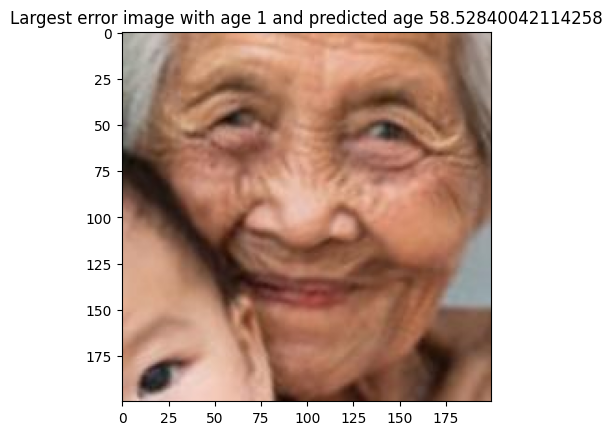

In [9]:
import matplotlib.pyplot as plt
import cv2

# Find the index of the max error
max_error_idx = np.argmax(absolute_errors)
max_error_image = cv2.imread(df['Images'].iloc[max_error_idx])

# Plot the image
plt.imshow(cv2.cvtColor(max_error_image, cv2.COLOR_BGR2RGB))
plt.title(
    f"Largest error image with age {df['Ages'].iloc[max_error_idx]} and predicted age {predicted_ages[max_error_idx]}")
plt.show()

1/1 [==============================] - 0s 41ms/step


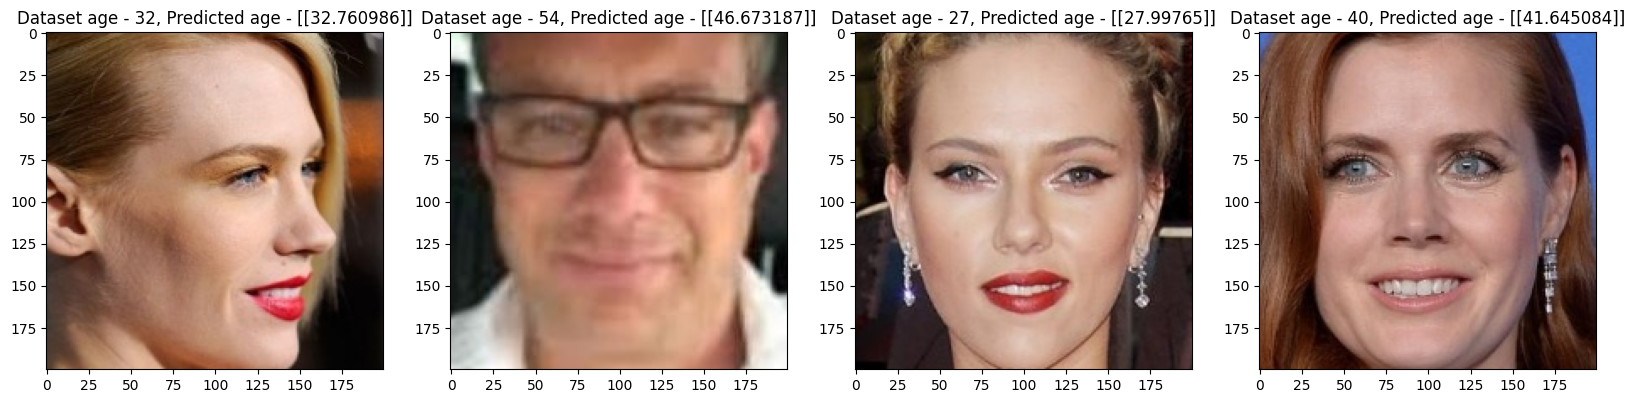

In [106]:
test_df = df.sample(frac=1).reset_index(drop=True)
i = 0
fix, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4):
    img = cv2.imread(test_df['Images'].iloc[i + idx])
    ax[idx].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax[idx].title.set_text('Dataset age - {0}, Predicted age - {1}'.format(test_df['Ages'].iloc[i + idx], agemodel.predict(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).reshape(1, 200, 200, 1) / 255)))

## Building confusion matrix

In [191]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [177]:
conf_df = df

In [178]:
def class_labels_reassign(age):

    if 0 <= age < 3:
        return 0
    elif 3 <= age < 10:
        return 1
    elif 10 <= age < 21:
        return 2
    elif 21 <= age < 28:
        return 3
    elif 28 <= age < 46:
        return 4
    elif 46 <= age < 66:
        return 5
    else:
        return 6

In [179]:
conf_df['Ages'] = df['Ages'].map(class_labels_reassign)
predicted_ages = np.array(predicted_ages)
reassign = np.vectorize(class_labels_reassign)
conf_predicted = reassign(predicted_ages)

In [182]:
conf_matrix = confusion_matrix(conf_df['Ages'].astype(int), conf_predicted)

In [183]:
conf_matrix

array([[ 1456,   125,    23,    10,     8,     1,     0],
       [  472,   714,   508,   123,    48,     4,     0],
       [   10,   221,  3050,  3211,   806,    20,     0],
       [    4,     0,  1226, 10490,  7065,    74,     1],
       [    2,     3,   197,  6090, 38587,  2910,    12],
       [    0,     1,    15,    99,  6419, 13655,   436],
       [    0,     0,     0,    16,   192,  2432,  1744]], dtype=int64)

In [192]:
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)

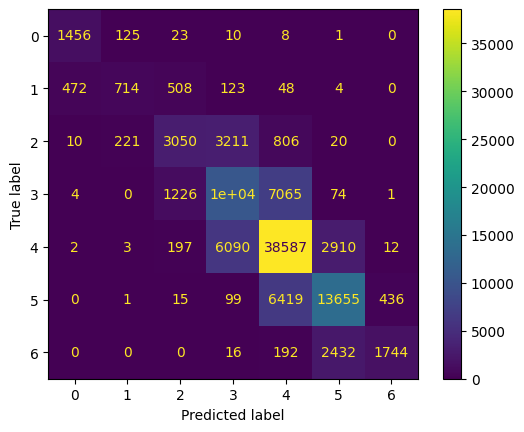

In [194]:
disp.plot()